# Initial Reviewing of Datasets

Dataset: Feedback Prize - English Language Learning - Evaluating language knowledge of ELL students from grades 8-12 

Dataset: Feedback Prize - English Language Learning - Evaluating language knowledge of ELL students from grades 8-12 

Source: https://www.kaggle.com/competitions/feedback-prize-english-language-learning/overview/evaluation

API Call: kaggle competitions download -c feedback-prize-english-language-learning

Goal Description: 
- Each measure represents a component of proficiency in essay writing, with greater scores corresponding to greater proficiency in that measure. The scores range from 1.0 to 5.0 in increments of 0.5. Your task is to predict the score of each of the six measures for the essays given in the test set.

Additional competition and datset: Feedback Prize - Predicting Effective Arguments https://www.kaggle.com/competitions/feedback-prize-effectiveness/data

I think we can do a random forest that can classify each outcome since they are categorical. We can engineer the parameters that are optimized for the scores. I think we can do a descending model, starting from a 5 then working down to a 1 if it fails the cut off. Or for smiplicity we can just look at an overall score by summing the outcomes. 

Natural language processing libraries and bag of words. 

# Version 0.3: Learning embedding via SVM
- Linear SVM
- if doesn't work try Naive Bayes

In [ ]:
# Download datase
# Add kaggle.json for own API key
# update kaggle_url.txt with kaggle api call

# !rm -fr ./data &> /dev/null
# !rm -f ./Automating_kaggle_dataset/kaggle_url.sh &> /dev/null
# !echo "kaggle competitions download -c feedback-prize-english-language-learning" >> ./Automating_kaggle_dataset/kaggle_url.sh
# !sh Automating_kaggle_dataset/download_kaggle_dataset.sh < ./Automating_kaggle_dataset/kaggle_url.sh &> /dev/null
# !echo "Data downloaded from kaggle"

In [2]:
from google.colab import drive
from google.colab import files

drive.mount('/content/drive')


Mounted at /content/drive


# Github setup

In [3]:
%cd "/content/drive/MyDrive/W207_final_project"

/content/drive/MyDrive/W207_final_project


In [4]:
!git config --global user.email "nick.lee@berkely.edu"

In [5]:
!git init 

Reinitialized existing Git repository in /content/drive/MyDrive/W207_final_project/.git/


In [6]:
%ls -l

total 11158
-rw------- 1 root root 11306373 Nov 25 21:38 eda_nick.ipynb
-rw------- 1 root root   113674 Nov 25 21:38 Final_project_NLP_NL_v0.3.ipynb
-rw------- 1 root root      104 Nov 25 21:38 README.md
drwx------ 2 root root     4096 Nov 25 21:15 w207_final_project/


In [7]:
# upload git token:
files.upload();

Saving git_token.txt to git_token.txt


In [8]:
username = "leen01"
with open("./git_token.txt", 'r') as file:
    git_token = file.read()
repository = "w207_final_project"

In [10]:
!git remote set-url origin https://{git_token}@github.com/{username}/{repository}

In [11]:
%cd "./w207_final_project/"

/content/drive/MyDrive/W207_final_project/w207_final_project


In [12]:
!git pull origin main

From https://github.com/leen01/w207_final_project
 * branch            main       -> FETCH_HEAD
Already up to date.


In [ ]:
!git status

In [30]:
!git clone https://{git_token}@github.com/{username}/{repository}

Cloning into 'w207_final_project'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 15 (delta 1), reused 3 (delta 0), pack-reused 0
Unpacking objects: 100% (15/15), done.


In [14]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   Final_project_NLP_NL_v0.3.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


In [15]:
!git add Final_project_NLP_NL_v0.3.ipynb
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes to be committed:
  (use "git reset HEAD <file>..." to unstage)

	modified:   Final_project_NLP_NL_v0.3.ipynb



In [16]:
!git commit -m "20221125 upload"

[main 0df3c03] 20221125 upload
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite Final_project_NLP_NL_v0.3.ipynb (94%)


In [17]:
!git push -u origin main

Counting objects: 3, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 2.31 KiB | 338.00 KiB/s, done.
Total 3 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/leen01/w207_final_project
   72085df..0df3c03  main -> main
Branch 'main' set up to track remote branch 'main' from 'origin'.


In [19]:
#git cleanup 
!rm ../git_token.txt

# Start of analysis

In [20]:
!pip install tensorflow keras nltk tensorflow_text sklearn shap &>/dev/null
!echo "Packages installed"

Packages installed


In [23]:
# standard
import pandas as pd
import numpy as np
import random
import os

# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords

# tf and keras
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import Dropout
import tensorflow_text as tf_text
import tensorflow_datasets as tfds

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

# shap
# import shap

# plots and images
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

# others
import re

from wordcloud import WordCloud
from collections import Counter
import warnings

warnings.filterwarnings("ignore")


In [ ]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [24]:
#silence TF
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

random.seed(2)
%matplotlib inline

# FILL IN CODE HERE #
DATA_PATH = '/content/drive/MyDrive/W207 Final Project/data/' # replace with your path

In [25]:
nltk.download('stopwords')
stops = set(stopwords.words('english'))
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [26]:
#  
def load_fresh_dataset(): 
  #EDA
  train = pd.read_csv(os.path.join(DATA_PATH, "train.csv"))
  test = pd.read_csv(os.path.join(DATA_PATH,"test.csv"))

  print("Train shape: ", train.shape)
  print(train.head())
  print("Test shape: ", test.shape)

  return train, test

def inspect_model(model):
  display(model.layers)
  display(model.summary())

  # Retrieve the embeddings layer, which itself is wrapped in a list.
  embeddings = model.layers[0].get_weights()[0]
  display("Embeddings layer - shape: ", embeddings.shape)
  display("Embeddings layer - parameter matrix (before training): ", embeddings)

# SVM model 1

In [27]:
train, test = load_fresh_dataset()

Train shape:  (3911, 8)
        text_id                                          full_text  cohesion  \
0  0016926B079C  I think that students would benefit from learn...       3.5   
1  0022683E9EA5  When a problem is a change you have to let it ...       2.5   
2  00299B378633  Dear, Principal\n\nIf u change the school poli...       3.0   
3  003885A45F42  The best time in life is when you become yours...       4.5   
4  0049B1DF5CCC  Small act of kindness can impact in other peop...       2.5   

   syntax  vocabulary  phraseology  grammar  conventions  
0     3.5         3.0          3.0      4.0          3.0  
1     2.5         3.0          2.0      2.0          2.5  
2     3.5         3.0          3.0      3.0          2.5  
3     4.5         4.5          4.5      4.0          5.0  
4     3.0         3.0          3.0      2.5          2.5  
Test shape:  (3, 2)


In [28]:
train.dtypes

run_SVM_model = False

if run_SVM_model == True: 
  train['vocabulary'] = train['vocabulary'].astype("string")

  X = train['full_text']
  y = train['vocabulary']

  vectorizer = CountVectorizer(stop_words='english')
  X_vec = vectorizer.fit_transform(X)
  X_vec = X_vec.todense()
  X_vec

  tfidf = TfidfTransformer() # by default applies "l2" normalization
  X_tfidf = tfidf.fit_transform(X_vec)
  X_tfidf = X_tfidf.todense()
  X_tfidf

  X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, 
                                                      test_size = 0.25, 
                                                      random_state = 0)

  classifier = SVC(kernel='linear')
  classifier.fit(X_train, y_train)

  y_pred = classifier.predict(X_test)

  confusion_matrix(y_test, y_pred)

## Functions

In [29]:
def preprocessor(text):
  """ 
    Removing puncuation, emoticons and stop words
  """
  # Remove ...
  text = re.sub('<[^>]*>', '', text)
  # Remove any 
  emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',
                          text)
  text = (re.sub('[\W]+', ' ', text.lower()) +
          ' '.join(emoticons).replace('-', ''))
  
  # Removing stop words
  
  return text

def stopword_removal(text): 
  words = word_tokenize(text)
  wordsFiltered = []
  for w in words:
      if w not in stops:
          wordsFiltered.append(w)
  text = " ".join(wordsFiltered)
  return text

# define function for token encoder
def encode(text_tensor, label):
    text = text_tensor.numpy()[0]
    encoded_text = encoder.encode(text)
    return encoded_text, label

#  wrap the encode function to a TF Operator
def encode_map_fn(text, label):
    return tf.py_function(encode, inp=[text, label], 
                          Tout=(tf.float64, tf.float64))
    
def pad_data(sequences, max_length):
  # Keras has a convenient utility for padding a sequence.
  # Also make sure we get a numpy array rather than an array of lists.
  return np.array(list(
      tf.keras.preprocessing.sequence.pad_sequences(
          sequences, maxlen=max_length, padding='post', value=0)))

In [30]:
train = pd.read_csv(os.path.join(DATA_PATH, "train.csv"))
test = pd.read_csv(os.path.join(DATA_PATH,"test.csv"))

print("Train shape: ", train.shape)
print(train.head())
print("Test shape: ", test.shape)

Train shape:  (3911, 8)
        text_id                                          full_text  cohesion  \
0  0016926B079C  I think that students would benefit from learn...       3.5   
1  0022683E9EA5  When a problem is a change you have to let it ...       2.5   
2  00299B378633  Dear, Principal\n\nIf u change the school poli...       3.0   
3  003885A45F42  The best time in life is when you become yours...       4.5   
4  0049B1DF5CCC  Small act of kindness can impact in other peop...       2.5   

   syntax  vocabulary  phraseology  grammar  conventions  
0     3.5         3.0          3.0      4.0          3.0  
1     2.5         3.0          2.0      2.0          2.5  
2     3.5         3.0          3.0      3.0          2.5  
3     4.5         4.5          4.5      4.0          5.0  
4     3.0         3.0          3.0      2.5          2.5  
Test shape:  (3, 2)


## Pre-process text
Remove Unwanted characters

In [31]:
# reshape
print("Shape ", train.shape)
print("Column names ", train.columns)

Shape  (3911, 8)
Column names  Index(['text_id', 'full_text', 'cohesion', 'syntax', 'vocabulary',
       'phraseology', 'grammar', 'conventions'],
      dtype='object')


In [32]:
# First pass
train['full_text'] = train['full_text'].apply(preprocessor)
train['full_text'].head()

# Second pass to remove stop words
train['full_text'] = train['full_text'].apply(stopword_removal)
train['full_text'].head()

0    think students would benefit learning home won...
1    problem change let best matter happening chang...
2    dear principal u change school policy grade b ...
3    best time life become agree greatest accomplis...
4    small act kindness impact people change people...
Name: full_text, dtype: object

In [33]:
# outputs are discrete rather than continuous
dtypes = {c: 'float64' for c in ('cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions')}
train = train.astype(dtypes)

In [34]:
train.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,think students would benefit learning home won...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,problem change let best matter happening chang...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,dear principal u change school policy grade b ...,3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,best time life become agree greatest accomplis...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,small act kindness impact people change people...,2.5,3.0,3.0,3.0,2.5,2.5


In [35]:
train.describe()

,cohesion,syntax,vocabulary,phraseology,grammar,conventions
count,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000
mean,3.127077,3.028254,3.235745,3.116850,3.032856,3.081053
std,0.662542,0.644399,0.583148,0.655997,0.699841,0.671450
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.500000,2.500000,3.000000,2.500000,2.500000,2.500000
50%,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
75%,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


# Analysis

In [36]:
df_vocab = train[['full_text', 'vocabulary']]
df_vocab.head()

,full_text,vocabulary
0,think students would benefit learning home won...,3.0
1,problem change let best matter happening chang...,3.0
2,dear principal u change school policy grade b ...,3.0
3,best time life become agree greatest accomplis...,4.5
4,small act kindness impact people change people...,3.0


In [37]:
df_vocab["full_text"][1]

'problem change let best matter happening change mind sometimes need wake look around problems best way change want change along time ago problem change make see different help understand tings wok first make see different others example remember came united states think nothing going change think nothing going change everything different country realist wrong problem may change sometimes change way remember really shy think change lot sometimes problems make think thing never see life need see different way dont let nothing happened ruing change want make problem example think nothing going change dont need shy anymore became need start seeing everything different ways get mad every one need know going happened people may see different way know change best let nothing body change nothing way want change one nothing choice problems decide second help understand things work instance mom lot problems faith around people mom scare high scare high understand mos scare high scare high every

In [38]:
target_vocab = df_vocab.pop('vocabulary')

In [39]:
target_vocab.head()

0    3.0
1    3.0
2    3.0
3    4.5
4    3.0
Name: vocabulary, dtype: float64

In [40]:
data_vocab_tf = tf.data.Dataset.from_tensor_slices(
    (df_vocab[['full_text']].values, target_vocab.values)
)

In [41]:
# inspection of the first 5 examples
for example in data_vocab_tf.take(5):
    # print review (first 40 characters) and sentiment (label)
    tf.print(example[0].numpy()[0][:40], example[1])

b'think students would benefit learning ho' 3
b'problem change let best matter happening' 3
b'dear principal u change school policy gr' 3
b'best time life become agree greatest acc' 4.5
b'small act kindness impact people change ' 3


In [42]:
tf.random.set_seed(26)
# splitting the datasets
splits = [0.6, 0.2, 0.2]

df_shape = df_vocab.shape[0]

data_vocab_tf = data_vocab_tf.shuffle(
    df_shape, reshuffle_each_iteration=False
)

# Look at doing a train test split with tensor flow
data_vocab_tf_test = data_vocab_tf.take(int(df_shape * splits[2]))
data_vocab_tf_train_valid = data_vocab_tf.skip(int(df_shape * splits[2]))
data_vocab_tf_train = data_vocab_tf_train_valid.take(int(df_shape * splits[0]))
data_vocab_tf_valid = data_vocab_tf_train_valid.skip(int(df_shape * splits[0]))

What is a take class? 

## ID unique words (tokens) in training dataset

In [43]:
# try and except the TF tokenizer
try:
    tokenizer = tfds.features.text.Tokenizer(padding="max_length")
except AttributeError:
    tokenizer = tfds.deprecated.text.Tokenizer(padding="max_length")

# create an instance of the Counter class
token_counts = Counter()

for example in data_vocab_tf_train:
    tokens = tokenizer.tokenize(example[0].numpy()[0])
    token_counts.update(tokens)
    
print('Size of training vocabulary:', len(token_counts))

Size of training vocabulary: 15918


Rowwise take each essay, process into lower case, remove stop words, remove numbers or change to text.
Look at frequency of words. 
Create tokens that are appropriate and generalizable to the entire dataset

In [44]:
word_frequencies = pd.DataFrame(token_counts.most_common())
word_frequencies.head()

,0,1
0,people,9243
1,students,7805
2,school,7706
3,good,5128
4,time,5064


In [47]:
word_frequencies = word_frequencies.rename({0:"x", 1:"y"}, axis = 1)
word_frequencies.describe()

,y
count,15918.000000
mean,29.013004
std,213.652621
min,1.000000
25%,1.000000
50%,2.000000
75%,5.000000
max,9243.000000


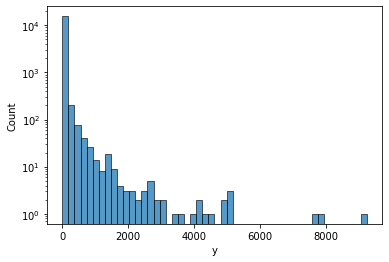

In [48]:
p = sns.histplot(data = word_frequencies, x = "y", bins = 50)
p.set_yscale('log')

## Number of Unique words by score

In [ ]:
# vectorize
# count unique vocab words

In [49]:
# Misspellings might be found in those that are not frequent
bag_of_words = word_frequencies.query("y > 10 and y < 1000")["x"].to_list()
print(len(bag_of_words))
print(bag_of_words[1:5])

2616
['may', 'dont', 'sometimes', 'everyone']


## Encoding sequences of words into sequences of integers

In [58]:
# create an instance of the TF encoder class
try:
    encoder = tfds.features.text.TokenTextEncoder(token_counts) # token_counts contains our training vocabulary
except AttributeError:
    encoder = tfds.deprecated.text.TokenTextEncoder(token_counts)


In [59]:
# try an example first (first 12 characters from the second review in training data)
example_str = 'My son took generic for about 6 months. His dr actually prescribed'
encoder.encode(example_str) # the encode method transforms the text into integers

[15919, 1664, 793, 5864, 15919, 15919, 1248, 2028, 15919, 3668, 255, 15919]

In [60]:
data_vocab_tf_train = data_vocab_tf_train.map(encode_map_fn)
data_vocab_tf_train_valid = data_vocab_tf_train_valid.map(encode_map_fn)
data_vocab_tf_test = data_vocab_tf_test.map(encode_map_fn)

In [1]:
# print first two examples in training data
word_ratio = []
for example in data_vocab_tf_train:
    print ('----------------------------')
    print('Sequence length:', example[0].shape)
    print('Unique words', len(np.unique(example[0])))
    print("Ratio length to unique words", (example[0].shape[0]/len(np.unique(example[0]))))
    word_ratio.append((example[0].shape[0]/len(np.unique(example[0]))))

    # print('Integer sequence:\n', example[0].numpy())

NameError: ignored

Divide the dataset into mini-batches as input to the model

In [73]:
batch_size = 64

def batch_data(data, batch_size = 64):
    batch =  data.padded_batch(batch_size, padded_shapes = ([-1], [])) 
    print(type(batch))
    return batch

# batcing of training, validation and test partitions
train_data = batch_data(data_vocab_tf_train)
valid_data = batch_data(data_vocab_tf_train_valid)
test_data = batch_data(data_vocab_tf_test)

<class 'tensorflow.python.data.ops.dataset_ops.PaddedBatchDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.PaddedBatchDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.PaddedBatchDataset'>


Average sequence length in training mini-batches: 466


Text(0.5, 0, 'Sequence length')

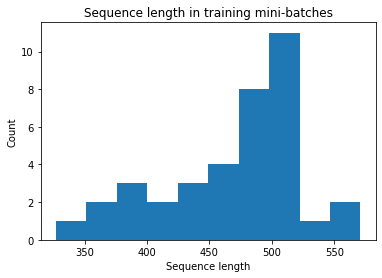

In [77]:
# histogram of sequence length in training mini-batches
seq_len_train = []
for batch in train_data:
    seq_len_train.append(batch[0].shape[1])
    
print('Average sequence length in training mini-batches:',
      int(sum(seq_len_train)/len(seq_len_train))
)

# # histogram
plt.hist(seq_len_train)
plt.title('Sequence length in training mini-batches')
plt.ylabel('Count')
plt.xlabel('Sequence length')

Look at relationships between: (Harry has done some of this already) 
- Length v. Outcome
- Unique words v. Outcome

## Build Model

Look into Transfer Learning Approach to Build model
BERT model

# Cornelia's example modified

In [96]:
def build_model(): 
  """
  Preprocessing reference # https://www.tensorflow.org/guide/keras/preprocessing_layers?authuser=1
  This model does not do the vectorization, assumes that has already been taken care of
  """
  vocab_train_size = len(token_counts) + 2
  
  output_dim = 32 # 128 -> 128 -> 32
  average_over_positions = True

  #   Clear session and remove randomness.

  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  model = tf.keras.Sequential()

  # vectorize
  # model.add(vectorize_layer)

  # vocab_train_size = len(vectorize_layer.get_vocabulary())
  # Embedd
  model.add(
      tf.keras.layers.Embedding(
          input_dim = vocab_train_size, 
          output_dim = output_dim, 
          input_length = 100, # Limiting length of sentence to 100 tokens
          name = 'embedding'
      )
  ),

  # Pooling layer
  # Average over the sequence dimension, so each essay is represented by 
  # 1 vector of size embedding_dimension
  model.add(tf.keras.layers.GlobalAveragePooling1D(name = "pooling")) 

  model.add(tf.keras.layers.Dense(
      units=128,        
      activation='relu', 
      name = 'relu1'))
  
  # add Dropout for regularization
  model.add(Dropout(0.5))

  model.add(tf.keras.layers.Dense(
      units=128,        
      activation='relu', 
      name = 'relu2'))
  
  # add Dropout for regularization
  model.add(Dropout(0.5))

  model.add(tf.keras.layers.Dense(
    units=32,        
    activation='relu', 
    name = 'relu3'))

  model.add(tf.keras.layers.Dense(
      units=9,        
      activation='sigmoid', 
      name = 'output'))
  
  # save embeddings before training 
  # embeddings_untrained = model.get_layer('embedding').get_weights()[0]

  # model.compile( Accuracy ~ 40%
  #     # optimizer=tf.keras.optimizers.Adam(1e-3),
  #     optimizer = tf.keras.optimizers.RMSprop(), # try different optimizers
  #     loss=tf.keras.losses.SparseCategoricalCrossentropy(), # try different loss functions - Cosine Similarity
  #     metrics=['accuracy'])

  model.compile(
    # optimizer=tf.keras.optimizers.Adam(1e-3),
    optimizer = tf.keras.optimizers.Adam(), # try different optimizers
    loss=tf.keras.losses.MeanSquaredError(), # try different loss functions - Cosine Similarity
    metrics=['accuracy'])

  return model


Models to try: 
Optimizers: 
- Adam
- 

Loss functions to try: 
- Mean Squared Error
- Logistic
- SparseCategoricalCrossentropy
- CategoricalCrossEntropy
- CosineSimilarity

In [97]:
model = build_model()

# Display the model layers
inspect_model(model)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           509440    
                                                                 
 pooling (GlobalAveragePooli  (None, 32)               0         
 ng1D)                                                           
                                                                 
 relu1 (Dense)               (None, 128)               4224      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 relu2 (Dense)               (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                        

None

'Embeddings layer - shape: '

(15920, 32)

'Embeddings layer - parameter matrix (before training): '

array([[-0.02080249, -0.02934336,  0.00353907, ...,  0.02517435,
        -0.03272872, -0.01880648],
       [-0.02086261, -0.03994876, -0.03343292, ...,  0.03752135,
        -0.00320397, -0.00300834],
       [ 0.01277483,  0.02302256,  0.04350588, ..., -0.00259702,
         0.04532841,  0.02332086],
       ...,
       [-0.03087389,  0.03150983,  0.04965499, ...,  0.04334423,
        -0.02125331, -0.007798  ],
       [-0.02457507,  0.02224917, -0.00572272, ..., -0.04020319,
         0.00590743,  0.02588277],
       [ 0.00701712, -0.02430736, -0.04799793, ...,  0.00070804,
         0.04678634, -0.04381863]], dtype=float32)

In [98]:
history = model.fit(
  train_data,  # our sparse padded training data
  validation_data = valid_data,  # corresponding labels
  epochs=5,    # number of passes through the training data
  verbose=0     # display some progress output during training
  )

history.history

{'loss': [7.491428852081299,
  5.733299732208252,
  5.294057846069336,
  5.29194974899292,
  5.291704177856445],
 'accuracy': [0.006393861956894398,
  0.0012787723680958152,
  0.022591644898056984,
  0.023870417848229408,
  0.03495310992002487],
 'val_loss': [6.710497856140137,
  5.342113494873047,
  5.337339401245117,
  5.337176322937012,
  5.337101459503174],
 'val_accuracy': [0.0,
  0.0,
  0.014062000438570976,
  0.06711409240961075,
  0.0754234567284584]}

In [81]:
model.predict(test_data)

13/13 [==============================] - 1s 47ms/step


array([[0.0196193 , 0.09862642, 0.9278159 , ..., 0.03929996, 0.00719525,
        0.00751989],
       [0.0261737 , 0.11461424, 0.9128694 , ..., 0.04958534, 0.01043594,
        0.01090211],
       [0.0248321 , 0.11141051, 0.91575533, ..., 0.0475067 , 0.00974056,
        0.01017948],
       ...,
       [0.03397134, 0.13077264, 0.8966967 , ..., 0.06109149, 0.0146006 ,
        0.01526233],
       [0.02195911, 0.10463569, 0.92234373, ..., 0.04299755, 0.00831508,
        0.00868445],
       [0.0217603 , 0.10423327, 0.9228943 , ..., 0.04266074, 0.00822457,
        0.00856948]], dtype=float32)

In [83]:
def plot_history(history):
  hist = history.history
  x_arr = np.arange(len(hist['loss'])) + 1

  fig = plt.figure(figsize=(12, 4))
  ax = fig.add_subplot(1, 2, 1)
  ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
  ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
  ax.legend(fontsize=15)
  ax.set_xlabel('Epoch', size=15)
  ax.set_ylabel('Loss', size=15)

  ax = fig.add_subplot(1, 2, 2)
  ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
  ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
  ax.legend(fontsize=15)
  ax.set_xlabel('Epoch', size=15)
  ax.set_ylabel('Accuracy', size=15)
  ax.set_ylim(0,1)
  plt.show()


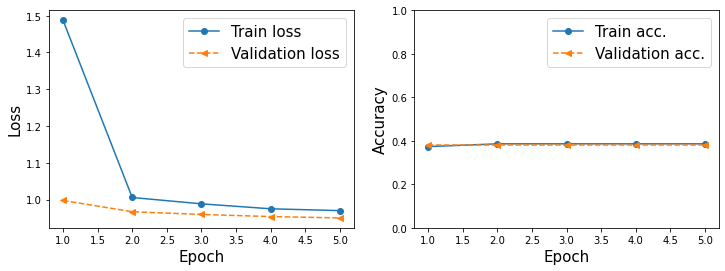

In [84]:
plot_history(history)

In [ ]:
# vocab_train_size = len(token_counts) + 2

# def vectorize_layer_fn():
#   vectorize_layer = tf.keras.layers.TextVectorization(
#         max_tokens=None, # Maximum vocabulary size - None -> no cap
#         standardize='lower_and_strip_punctuation', # Standarization to apply to text - None -> no standarization
#         split="whitespace", # Values can be None (no splitting), "whitespace", or a Callable
#         output_mode='int',  # Values can be "int", "multi_hot", "count" or "tf_idf"
#         output_sequence_length= vocab_train_size, # Only valid in INT mode. If set, the output will have its time dimension padded or truncated to exactly output_sequence_length values
#         )

#   vectorize_layer.adapt(np.array(train['full_text']))

#   return vectorize_layer

# vectorize_layer = vectorize_layer_fn()
# vectorize_layer
# # vectorize_layer.get_vocabulary()

# def build_vectorization_model(): 
#   """
#   Preprocessing reference # https://www.tensorflow.org/guide/keras/preprocessing_layers?authuser=1
#   Text vectorization
#   """
#   vocab_train_size = len(token_counts) + 2
  
#   output_dim = 32 # 128 -> 128 -> 32
#   average_over_positions = True

#   # def build_nlp_model():
#   #   Clear session and remove randomness.

#   tf.keras.backend.clear_session()
#   tf.random.set_seed(0)

#   model = tf.keras.Sequential()

#   # vectorize
#   model.add(vectorize_layer)

#   # vocab_train_size = len(vectorize_layer.get_vocabulary())
#   # Embedd
#   model.add(
#       tf.keras.layers.Embedding(
#           input_dim = vocab_train_size, 
#           output_dim = output_dim, 
#           input_length = 100, # Limiting length of sentence to 100 tokens
#           name = 'embedding'
#       )
#   ),

#   # Pooling layer
#   # Average over the sequence dimension, so each review is represented by 
#   # 1 vector of size embedding_dimension
#   model.add(tf.keras.layers.GlobalAveragePooling1D(name = "pooling")) 

#   model.add(tf.keras.layers.Dense(
#       units=9,        
#       activation='relu', 
#       name = 'relu'))
  
#   # add Dropout for regularization
#   model.add(Dropout(0.5))

#   model.add(tf.keras.layers.Dense(
#       units=9,        
#       activation='softmax', 
#       name = 'output'))
  
#   # save embeddings before training 
#   # embeddings_untrained = model.get_layer('embedding').get_weights()[0]

#   model.compile(
#       optimizer=tf.keras.optimizers.Adam(1e-3),
#       loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#       metrics=['accuracy'])

#   return model


In [ ]:
# history = model.fit(
#   x = np.array(train['full_text']),  # our sparse padded training data
#   y = target_vocab,  # corresponding labels
#   epochs=5,    # number of passes through the training data
#   verbose=0     # display some progress output during training
#   )
# history.history


In [ ]:
# experiments = {}
# def build_nlp_model():
#     vocab_train_size = len(token_counts) + 2 # I want to train on a smaller vocabulary and see if that makes a difference
#     embedding_dim = 32
#     average_over_positions = True
#     epochs = 5

#     training_log = {
#         "vocab_train_size": vocab_train_size,
#         "embedding_dim": embedding_dim,
#         "average_over_positions": average_over_positions,
#         "epochs": epochs
#     }

#     #   Clear session and remove randomness.
#     tf.keras.backend.clear_session()
#     tf.random.set_seed(0)

#     model = tf.keras.Sequential()

#     model.add(
#         Embedding(
#             input_dim = vocab_train_size, 
#             output_dim = embedding_dim, 
#             # input_length = 100, # Limiting length of sentence to 100 tokens
#             name = 'embedding'
#         )
#     ),

#     # how many layers are needed? 
#     # one for each output to learn different features of the data? 
#     # do people use random forests in NLP? 
#     if average_over_positions: 
#         model.add(GlobalAveragePooling1D()), 
#     else: 
#         model.add(tf.keras.layers.Flatten())

#     model.add(Dense(12, activation = 'relu')), 

#     model.add(Dropout(0.5)),

#     model.add(Dense(12, activation = 'relu')),

#     model.add(Dense(1, activation = 'sigmoid')) # output will be the 7 dimensions for the classifiers

#     embeddings_untrained = model.get_layer('embedding').get_weights()[0]

#     # Print model summary
#     print(model.summary())

#     # Compile model
#     model.compile(
#         loss='binary_crossentropy', 
#         optimizer='adam',
#         metrics=['accuracy'])

#     # Fit model
#     history = model.fit(
#         train_data, 
#         validation_data = valid_data, 
#         epochs=epochs
#     )
    
#     # training_log.update(history.history)
#     for idx, key in enumerate(history.history):
#         training_log[key] = history.history[key][4]

#     return training_log

# Context encoding
- Looking at word similarities and context

Efficiency Score: 
def efficiency_score():

## Evaluation: 
MCRMSE: mean columnwise root mean square error.
$N_t$ is the number of scored ground truth target columns and y and $y^{hat}$ are the actual and predicted values. 

In [ ]:
# F1 Score - harmonic mean of the precision and recall best value at 1, worst at 0. 
# F1 = 2 * (precision * recall) / (precesion + recall)
# good for unbalanced dataset. How do you tell if data is unbalanced? 

# Sparse Categorical Accuracy - calculates how often predictions match integer labels, it checks to see if hte maximal true value is equal to the index of the maximal predicted value


In [ ]:
# Ridge regression - Look at other classifiers
# clf = sklearn.linear_model.RidgeClassifier()

In [ ]:
# Model Building - predict vocabulary. 

# Siimilar meanings - Universal Sentence Encoder (USE) for word embeddings

# train test split
# X_train, X_test, y_train, y_test = train_test_split(train.toarray(), y, test_size=0.3, random_state=0)
# model

# training

# testing

# validation